# Evaluation of 1 Model With Physgen
-> Phys Anything

In [132]:
model_name = "phys_any_1"
variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined
encoder = "vitl"    # vits, vitb, vitl, vitg

### Env Setup

Follow the README  env installation steps and set 'phy_any' as the active python env.

### Imports

In [133]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [134]:
!python --version

Python 3.12.9


### Helper

In [135]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Inference

In [136]:
command = (
  f"python inference.py "
  f"--variation {variation} "
  f"--model_name {model_name} "
  f"--encoder {encoder} "
  # f"--save_only_result"
)

# Finally run it
!{command}

xFormers not available
xFormers not available
found newest model: phys_any_1_epoch139.pth
PhysGen (sound_reflection) Dataset for test got created
Progress 1/1244
    -> saved pred at ./eval/phys_any_1/pred/phys_any_1_0.png
    -> saved real at ./eval/phys_any_1/real/phys_any_1_0.png
    -> saved osm at ./eval/phys_any_1/osm/phys_any_1_0.png
Progress 2/1244
    -> saved pred at ./eval/phys_any_1/pred/phys_any_1_1.png
    -> saved real at ./eval/phys_any_1/real/phys_any_1_1.png
    -> saved osm at ./eval/phys_any_1/osm/phys_any_1_1.png
Progress 3/1244
    -> saved pred at ./eval/phys_any_1/pred/phys_any_1_2.png
    -> saved real at ./eval/phys_any_1/real/phys_any_1_2.png
    -> saved osm at ./eval/phys_any_1/osm/phys_any_1_2.png
Progress 4/1244
    -> saved pred at ./eval/phys_any_1/pred/phys_any_1_3.png
    -> saved real at ./eval/phys_any_1/real/phys_any_1_3.png
    -> saved osm at ./eval/phys_any_1/osm/phys_any_1_3.png
Progress 5/1244
    -> saved pred at ./eval/phys_any_1/pred/phys_a

### Calc Eval metrics

In [137]:
!python eval_metrics.py \
    --data_dir ./eval/{model_name}/real \
    --pred_dir ./eval/{model_name}/pred \
    --osm_dir ./eval/{model_name}/osm \
    --output ./eval_results/evaluation_{model_name}.csv

Evaluating samples: 100%|███████████████████| 1244/1244 [00:25<00:00, 49.26it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1244.000000  1244.000000  ...  1244.000000  1244.000000
mean      2.455549    46.455223  ...    30.450079    94.629539
std       1.139353    16.610390  ...    16.038744    16.683746
min       0.463167    13.086833  ...     4.077591    58.001034
25%       1.597599    33.792631  ...    18.519919    83.986212
50%       2.234134    44.230539  ...    26.783429    92.157375
75%       3.104269    56.903302  ...    39.549142   101.459200
max       7.139936   118.404861  ...   130.544601   254.759918

[8 rows x 6 columns]


### Show Results

In [138]:
mae_model_name = f'MAE_{model_name}'
los_mae_model_name = f'LoS_MAE_{model_name}'
nlos_mae_model_name = f'NLoS_MAE_{model_name}'
mape_model_name = f'MAPE_{model_name}'
los_wmape_model_name = f'LoS_wMAPE_{model_name}'
nlos_wmape_model_name = f'NLoS_wMAPE_{model_name}'

In [139]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_name}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_name, 
                            'LoS_MAE': los_mae_model_name,
                            'NLoS_MAE': nlos_mae_model_name,
                            'MAPE':mape_model_name,
                            'LoS_wMAPE': los_wmape_model_name,
                            'NLoS_wMAPE': nlos_wmape_model_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
merged_df = df_1
df_1

Nan found in sample ids: 0


sample_id  MAE_phys_any_1  MAPE_phys_any_1  LoS_MAE_phys_any_1  \
0             1        1.791883        49.517070            1.193172   
1             1        2.133100        49.593838            1.770134   
2             1        4.184223        45.772600            3.033548   
3             1        2.035425        49.701035            1.083122   
4             1        2.221185        54.104767            2.527095   
...         ...             ...              ...                 ...   
1239          1        0.666378        21.122517            0.672937   
1240          1        1.125567        19.385824            0.945877   
1241          1        2.493880        31.141819            1.670364   
1242          1        3.244044        47.644005            3.071101   
1243          1        1.182683        28.868437            0.870814   

      NLoS_MAE_phys_any_1  LoS_wMAPE_phys_any_1  NLoS_wMAPE_phys_any_1  
0                4.001813             37.971596              92.133040  
1                3.603850             32.014470             120.825910  
2                8.361856             28.321932             109.128940  
3                3.473819             25.839670              85.742110  
4                1.857214             32.236263              80.123750  
...                   ...                   ...                    ...  
1239             0.640423              5.477625              83.023140  
1240             1.937542              8.626858              68.002655  
1241             6.613328             16.587475             103.946560  
1242             4.027273             37.565840              93.286156  
1243             2.832089             19.457764              78.639340  

[1244 rows x 7 columns]

Using 'seaborn-v0_8' plotting style.

MAE: 2.46

MAPE: 46.46

LoS MAE: 1.90

NLoS MAE: 4.19

LoS wMAPE: 30.45

NLoS wMAPE: 94.63


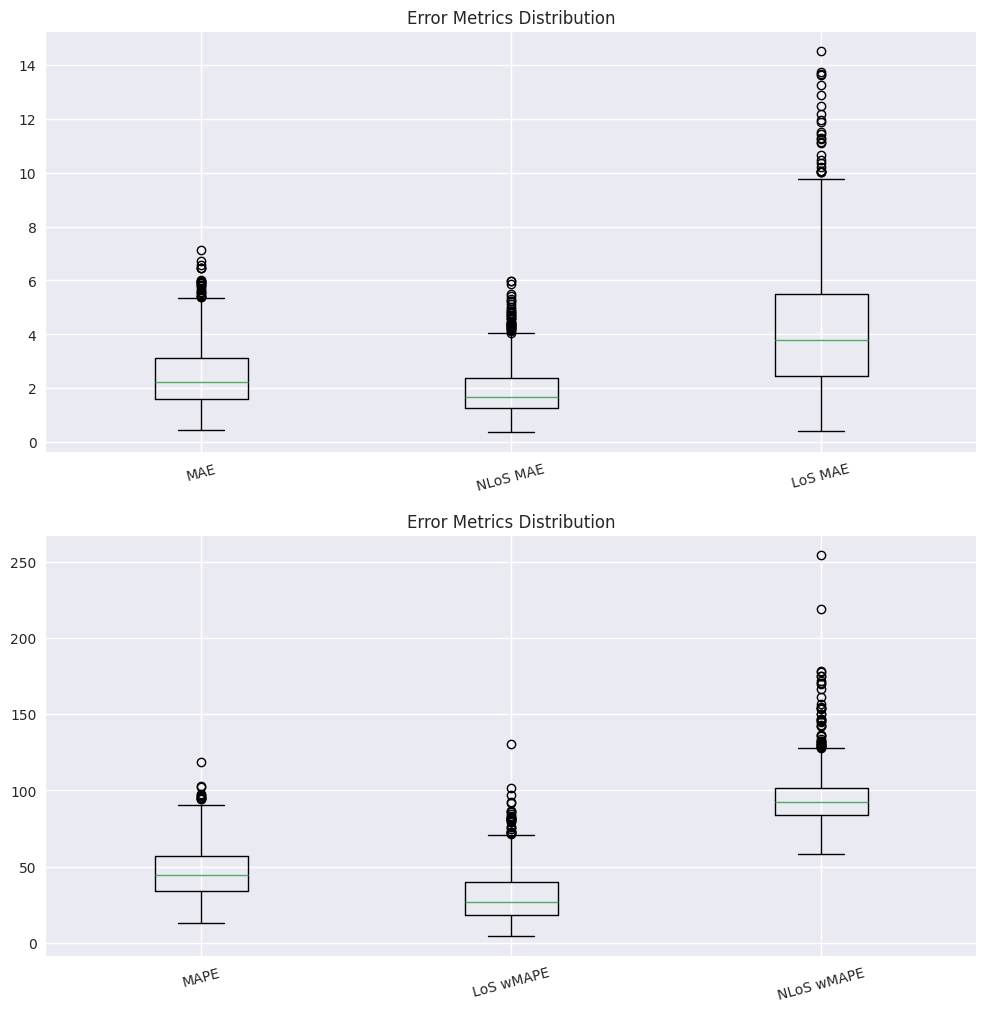

In [140]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

values_0 = [
    merged_df[mae_model_name],
    merged_df[los_mae_model_name],
    merged_df[nlos_mae_model_name],
]

labels_0 = [
    "MAE",
    "NLoS MAE",
    "LoS MAE"
]

values_1 = [
    merged_df[mape_model_name],
    merged_df[los_wmape_model_name],
    merged_df[nlos_wmape_model_name]
]

labels_1 = [
    "MAPE",
    "LoS wMAPE",
    "NLoS wMAPE"
]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].boxplot(values_0, notch=False)
ax[0].set_xticks(range(1, len(labels_0) + 1))
ax[0].set_xticklabels(labels_0, rotation=15)
ax[0].set_title("Error Metrics Distribution")

ax[1].boxplot(values_1, notch=False)
ax[1].set_xticks(range(1, len(labels_1) + 1))
ax[1].set_xticklabels(labels_1, rotation=15)
ax[1].set_title("Error Metrics Distribution")



print(f"\nMAE: {merged_df[mae_model_name].mean():>0.2f}")
print(f"\nMAPE: {merged_df[mape_model_name].mean():>0.2f}")
print(f"\nLoS MAE: {merged_df[los_mae_model_name].mean():>0.2f}")
print(f"\nNLoS MAE: {merged_df[nlos_mae_model_name].mean():>0.2f}")
print(f"\nLoS wMAPE: {merged_df[los_wmape_model_name].mean():>0.2f}")
print(f"\nNLoS wMAPE: {merged_df[nlos_wmape_model_name].mean():>0.2f}")

Example Image

In [141]:
def get_same_pred_real_samples(pred_path:str, real_path:str, input_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            cur_id = cur_id[-1]
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    if input_path:
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    real_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found real image with id: {target_id}")

    target_samples = [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    # get real image
    input_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(input_path):
            cur_id = re.findall('\d+', string=cur_image)
            cur_id = cur_id[-1]
            if cur_id == target_id:
                input_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found input image with id: {target_id}")

    input_samples = [os.path.join(input_path, cur_image) for cur_image in input_image_samples]

    return input_samples, target_samples, pred_samples, ids

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_992723/1261836018.py:21: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)
/tmp/ipykernel_992723/1261836018.py:38: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)
/tmp/ipykernel_992723/1261836018.py:55: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)


In [142]:
# from matplotlib.colors import ListedColormap

# def get_unique_hsv_cmap():
#     unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
#     hsv_map = plt.get_cmap("hsv")
#     for cur_idx in range(256):
#         r, g, b, a = hsv_map(cur_idx)
#         if r > 0.99 and g < (170/255):
#             gray_value = cur_idx*8 / 255.0
#             unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
#         else:
#             break
#     unique_hsv = ListedColormap(unique_hsv_map)
#     plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
#     return unique_hsv

# get_unique_hsv_cmap()
# plt.get_cmap("unique_hsv")

In [143]:
def plot(ax, path, title="", sub_image=None, cmap="plasma", plot=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = 255 - img

    if sub_image:
        img_2 = cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_2 = 255 - img_2

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)
        # img = img - img_2
        # img[img < 0] = img[img < 0] * -1

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=0, vmax=255)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

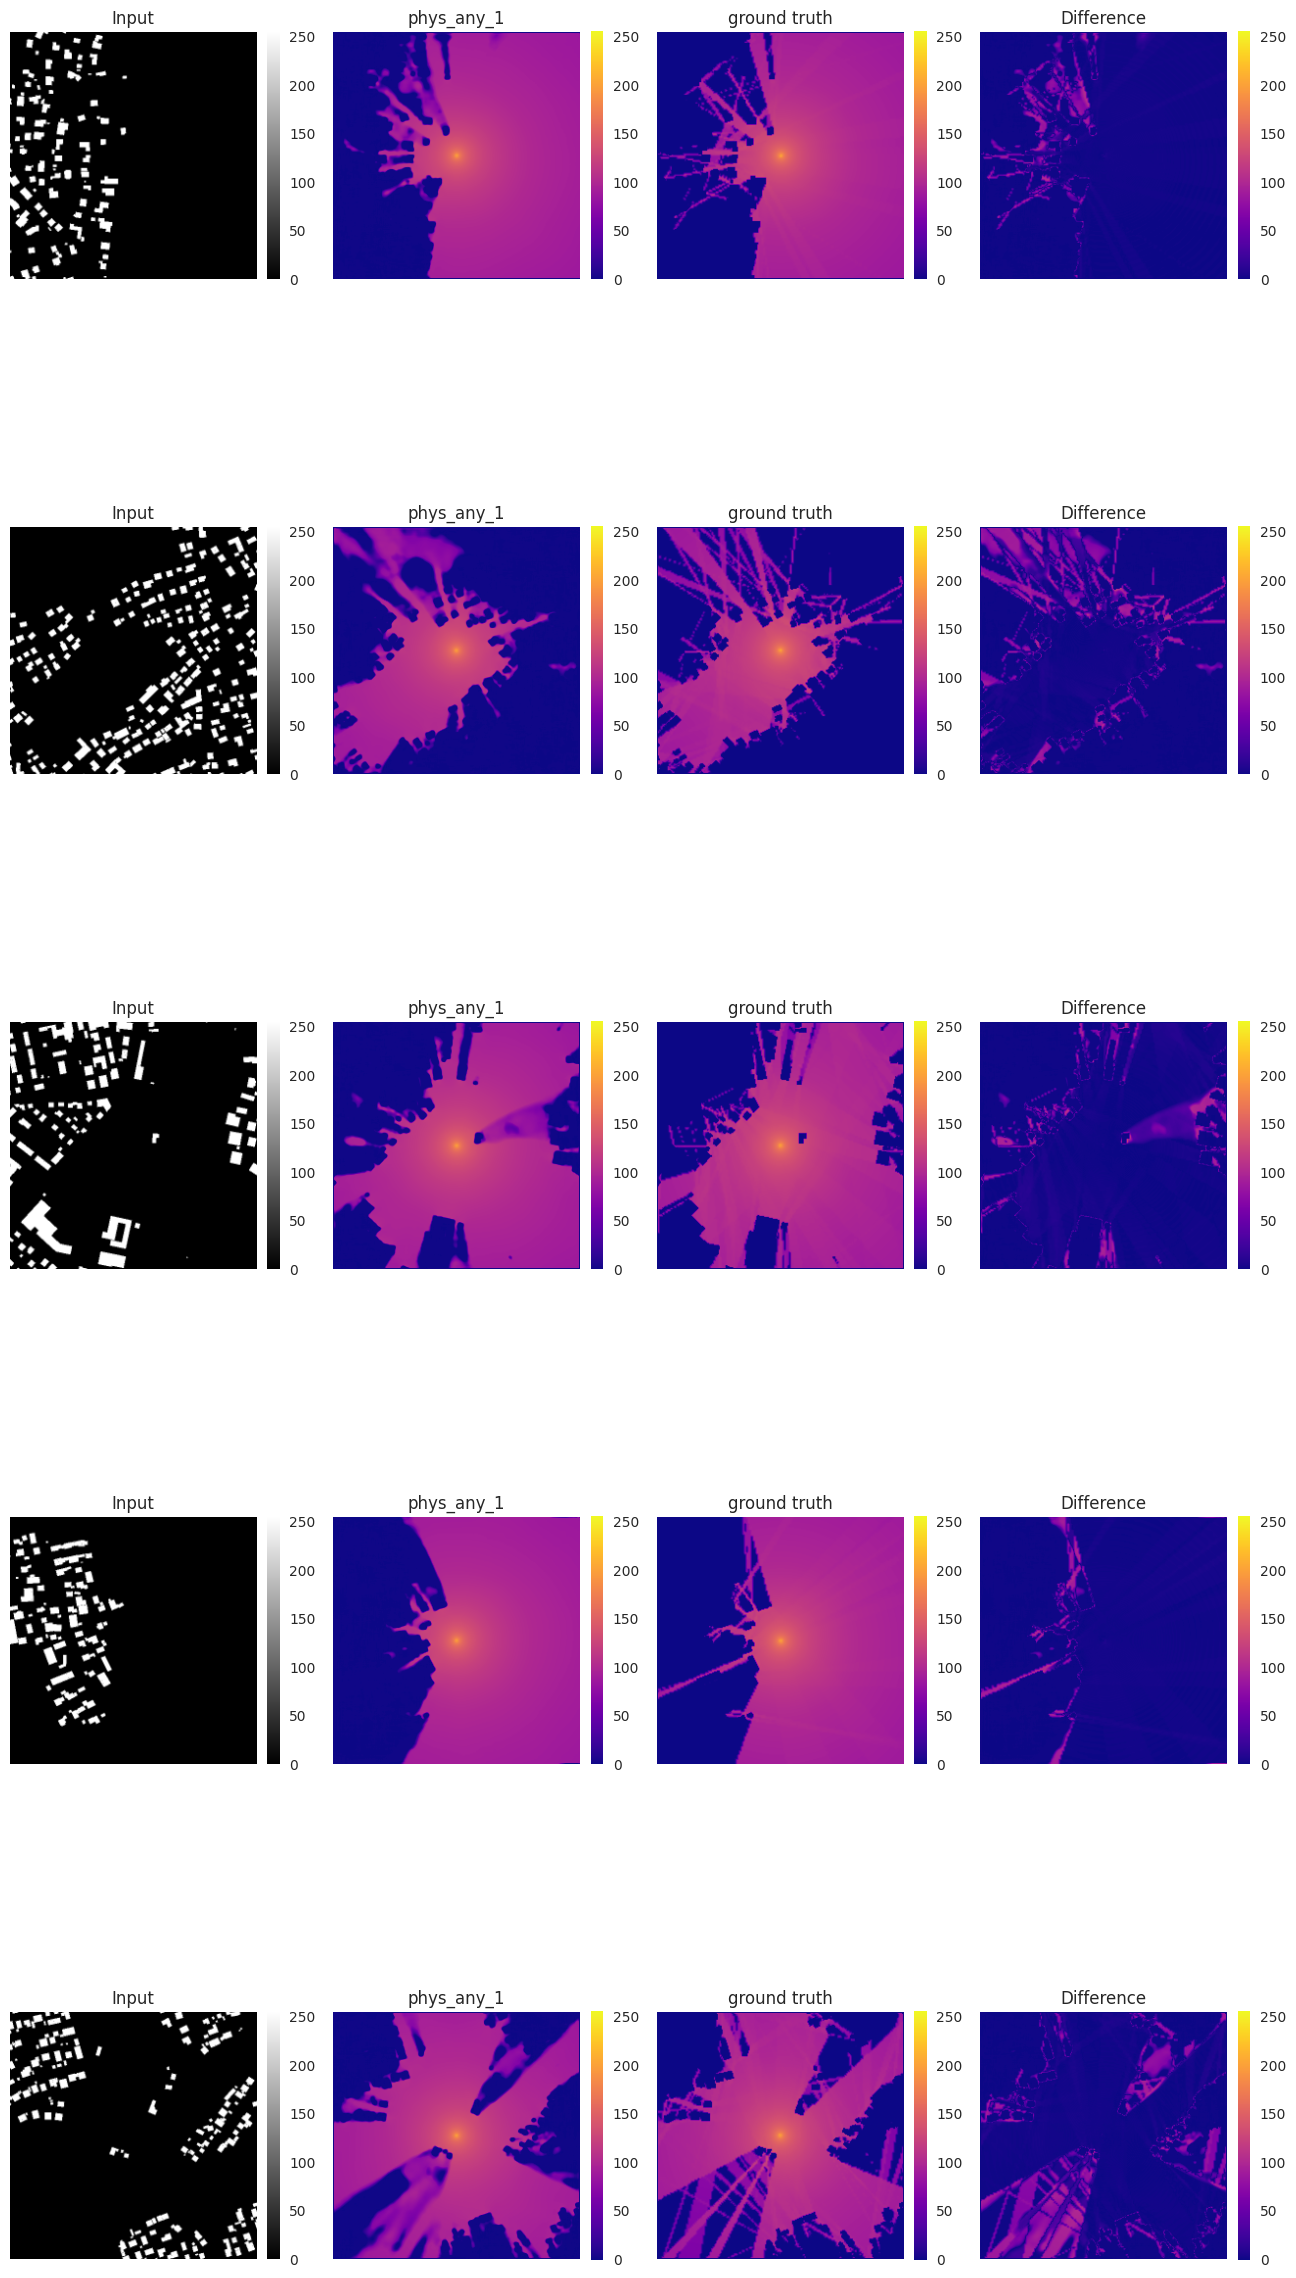

In [144]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"./eval/{model_name}/pred",
                                                                  f"./eval/{model_name}/real",
                                                                  f"./eval/{model_name}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"{model_name}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

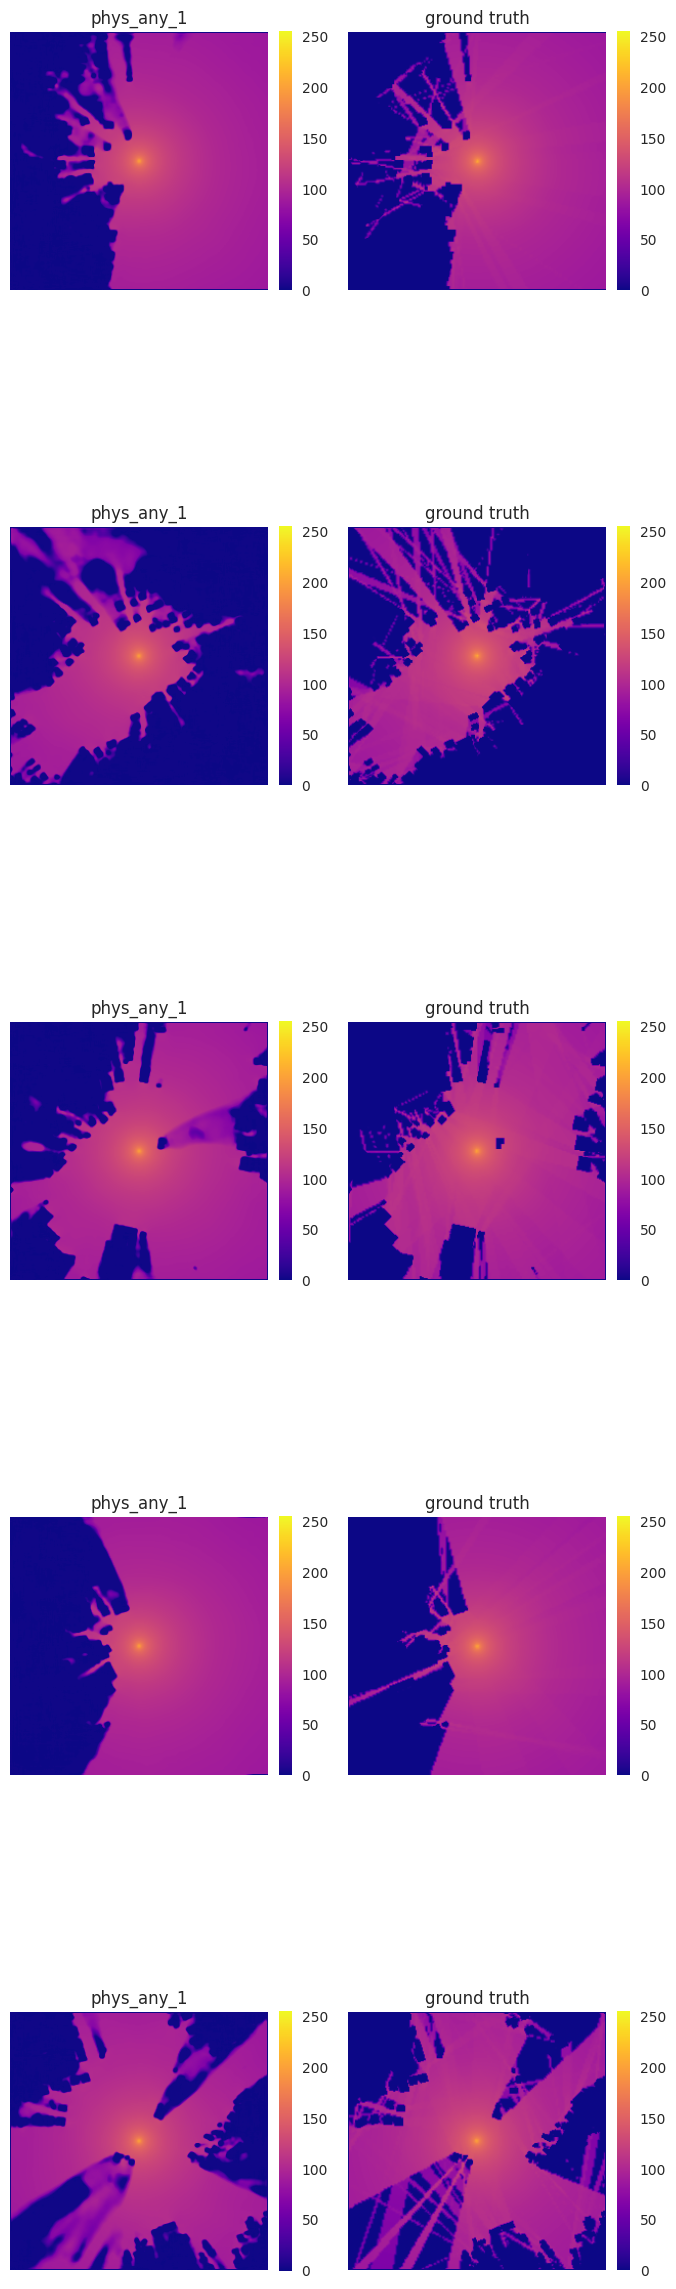

In [145]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][0], path=cur_path, title=f"{model_name}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][1], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

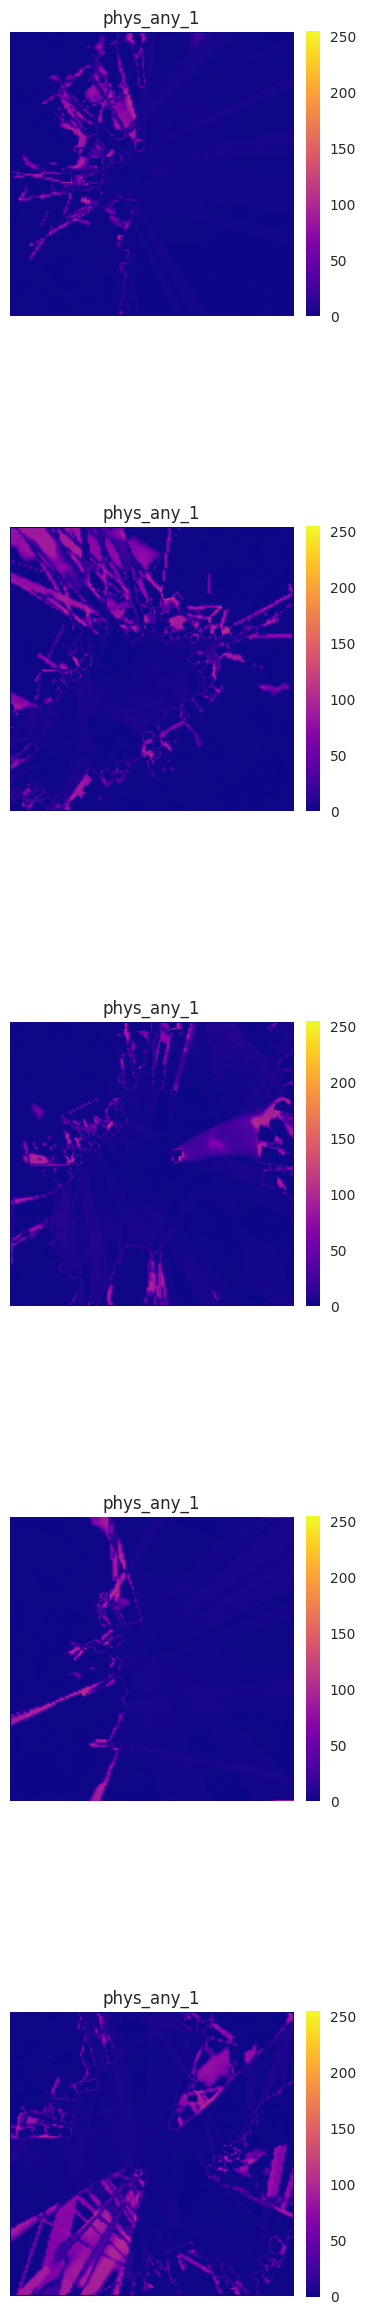

In [146]:
fig, ax = plt.subplots(nrows=n_samples, ncols=1, figsize=(1*4, n_samples*6))

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx], path=cur_path, title=f"{model_name}", sub_image=real[idx], cmap="plasma")

plt.subplots_adjust(hspace=0.5)
plt.show();

Inspect some single images in more detail here:

In [148]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8, ax=None):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    # Create figure/axes if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Show image
    im = ax.imshow(mean_img, cmap='gray', interpolation='nearest')
    
    # Annotate each block with its mean value
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = int(mean_img[i, j])
            color = 'white' if val < max_value / 1.5 else 'black'
            ax.text(j, i, f'{val}', ha='center', va='center',
                    color=color, fontsize=6)

    # Optional colorbar if ax was not passed
    if ax is None:
        plt.colorbar(im, ax=ax, label='Mean Value')
        ax.set_title(f'Mean Values over {block_size}x{block_size} Blocks')

    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if ax is None:
        plt.show()

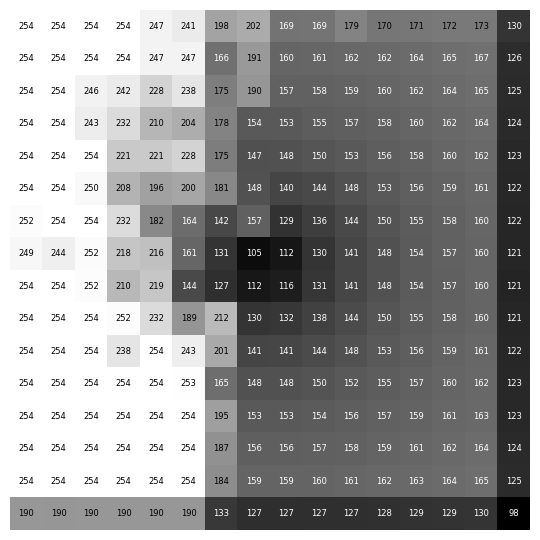

In [149]:
img_path = pred_model[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

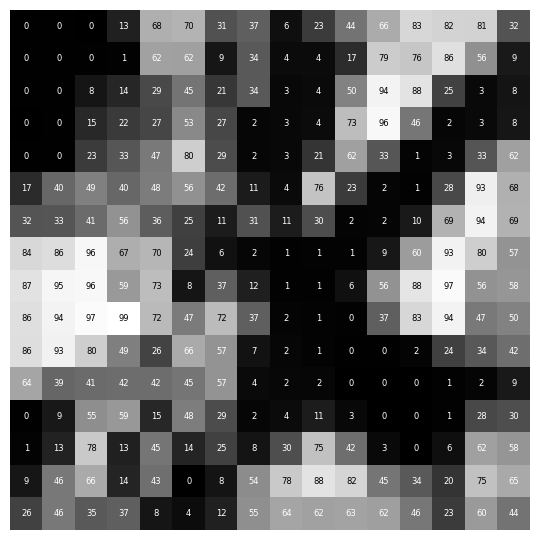

In [150]:
img = plot(None, path=pred_model[0], title=f"{model_name}", sub_image=real[idx], plot=False)
plot_image_with_values(img, block_size=16)

### Indepth Analysis

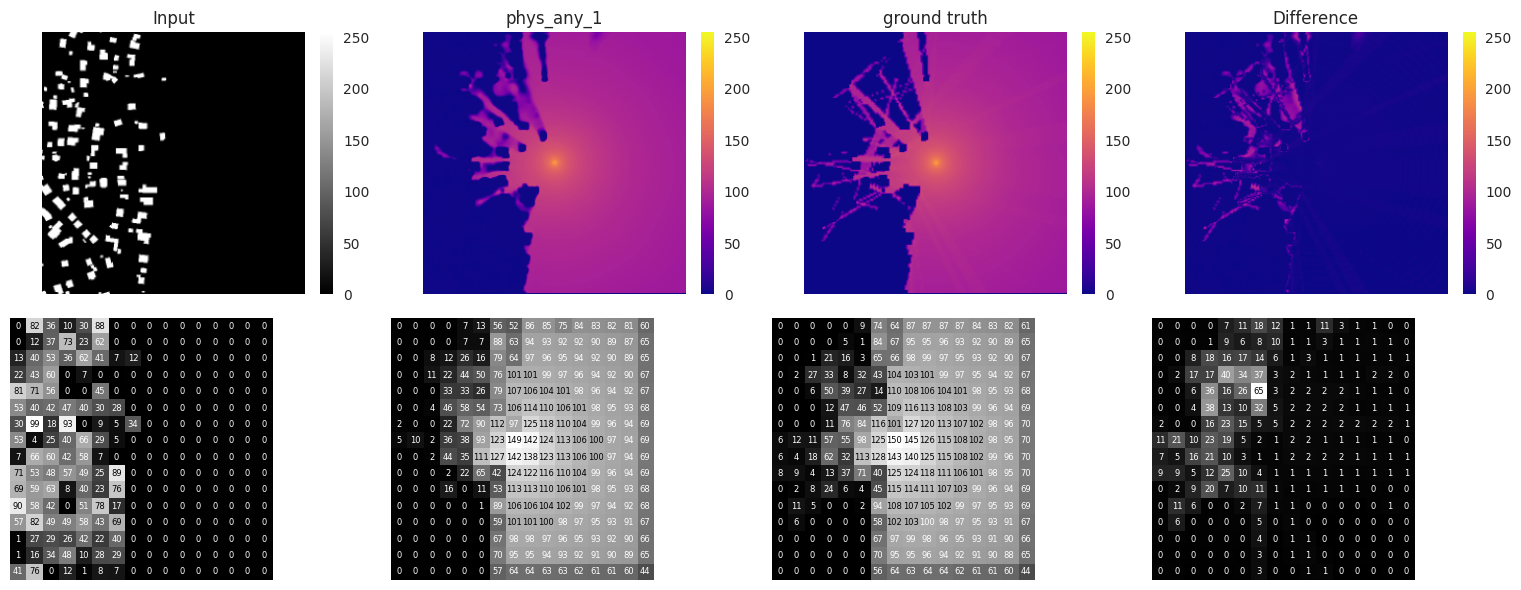

In [151]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(4*4, 6))

idx = 0
ax_idx = 0

img_1 = plot(ax[0][0], path=input_samples[idx], title=f"Input", cmap="gray")
plot_image_with_values(img_1, block_size=16, ax=ax[1][0])

img_2 = plot(ax[0][1], path=pred_model[idx], title=f"{model_name}")
plot_image_with_values(img_2, block_size=16, ax=ax[1][1])

img_3 = plot(ax[0][2], path=real[idx], title=f"ground truth")
plot_image_with_values(img_3, block_size=16, ax=ax[1][2])

img_4 = plot(ax[0][3], path=pred_model[idx], title=f"Difference", sub_image=real[idx])
plot_image_with_values(img_4, block_size=16, ax=ax[1][3])

# plt.subplots_adjust(hspace=0.5)

plt.show();

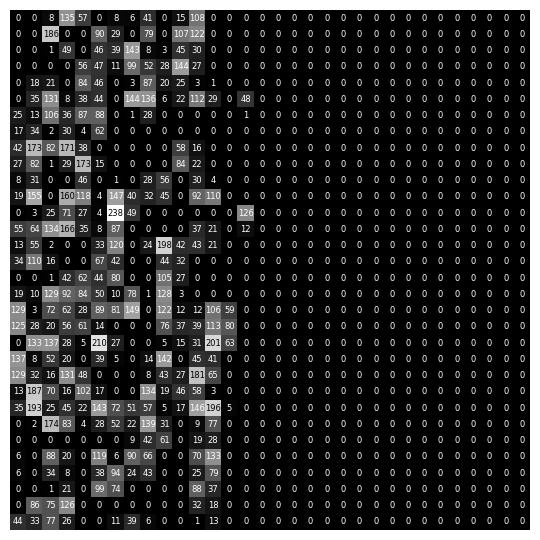

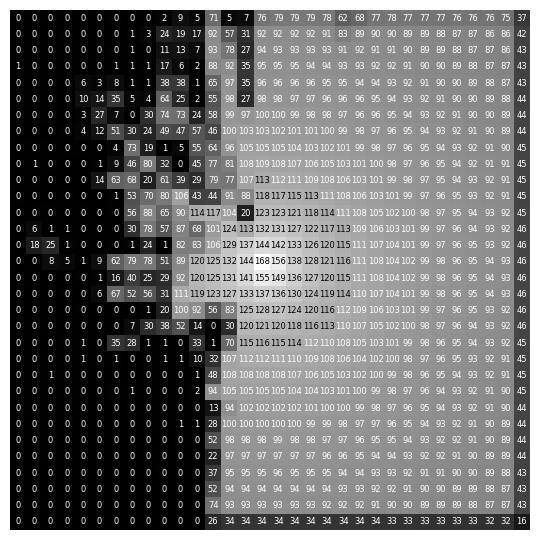

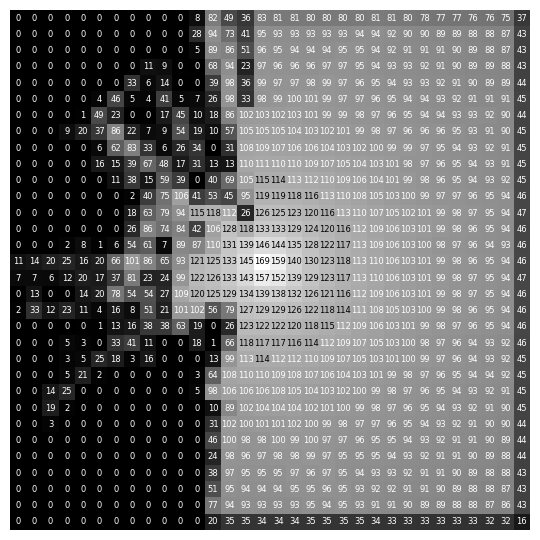

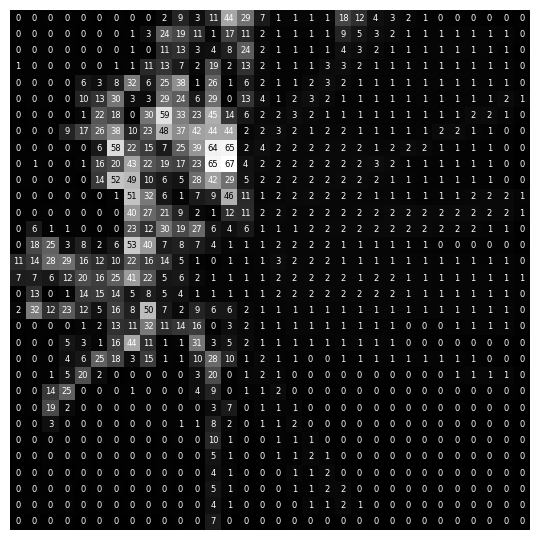

In [152]:
plot_image_with_values(img_1, block_size=8)
plot_image_with_values(img_2, block_size=8)
plot_image_with_values(img_3, block_size=8)
plot_image_with_values(img_4, block_size=8)

In [153]:
def plot_grayscale_line(img, axis='row', index=None):
    """
    Extract and plot a single row or column of pixel values from a grayscale image.

    Parameters:
    - img: 2D NumPy array (grayscale image, values in [0.0, 1.0] or [0, 255])
    - axis: 'row' or 'column' – which direction to extract
    - index: index of the row or column (default = center)
    """
    assert axis in ['row', 'column'], "axis must be 'row' or 'column'"

    h, w = img.shape
    if index is None:
        index = h // 2 if axis == 'row' else w // 2

    values = img[index, :] if axis == 'row' else img[:, index]
    x = np.arange(len(values))

    plt.figure(figsize=(6, 3))
    plt.plot(x, values, color='black', linewidth=1)
    plt.title(f'Pixel values along {axis} {index}')
    plt.xlabel('Pixel index')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return values  # Return 1D array

In [154]:
axis = "row"
index = 230

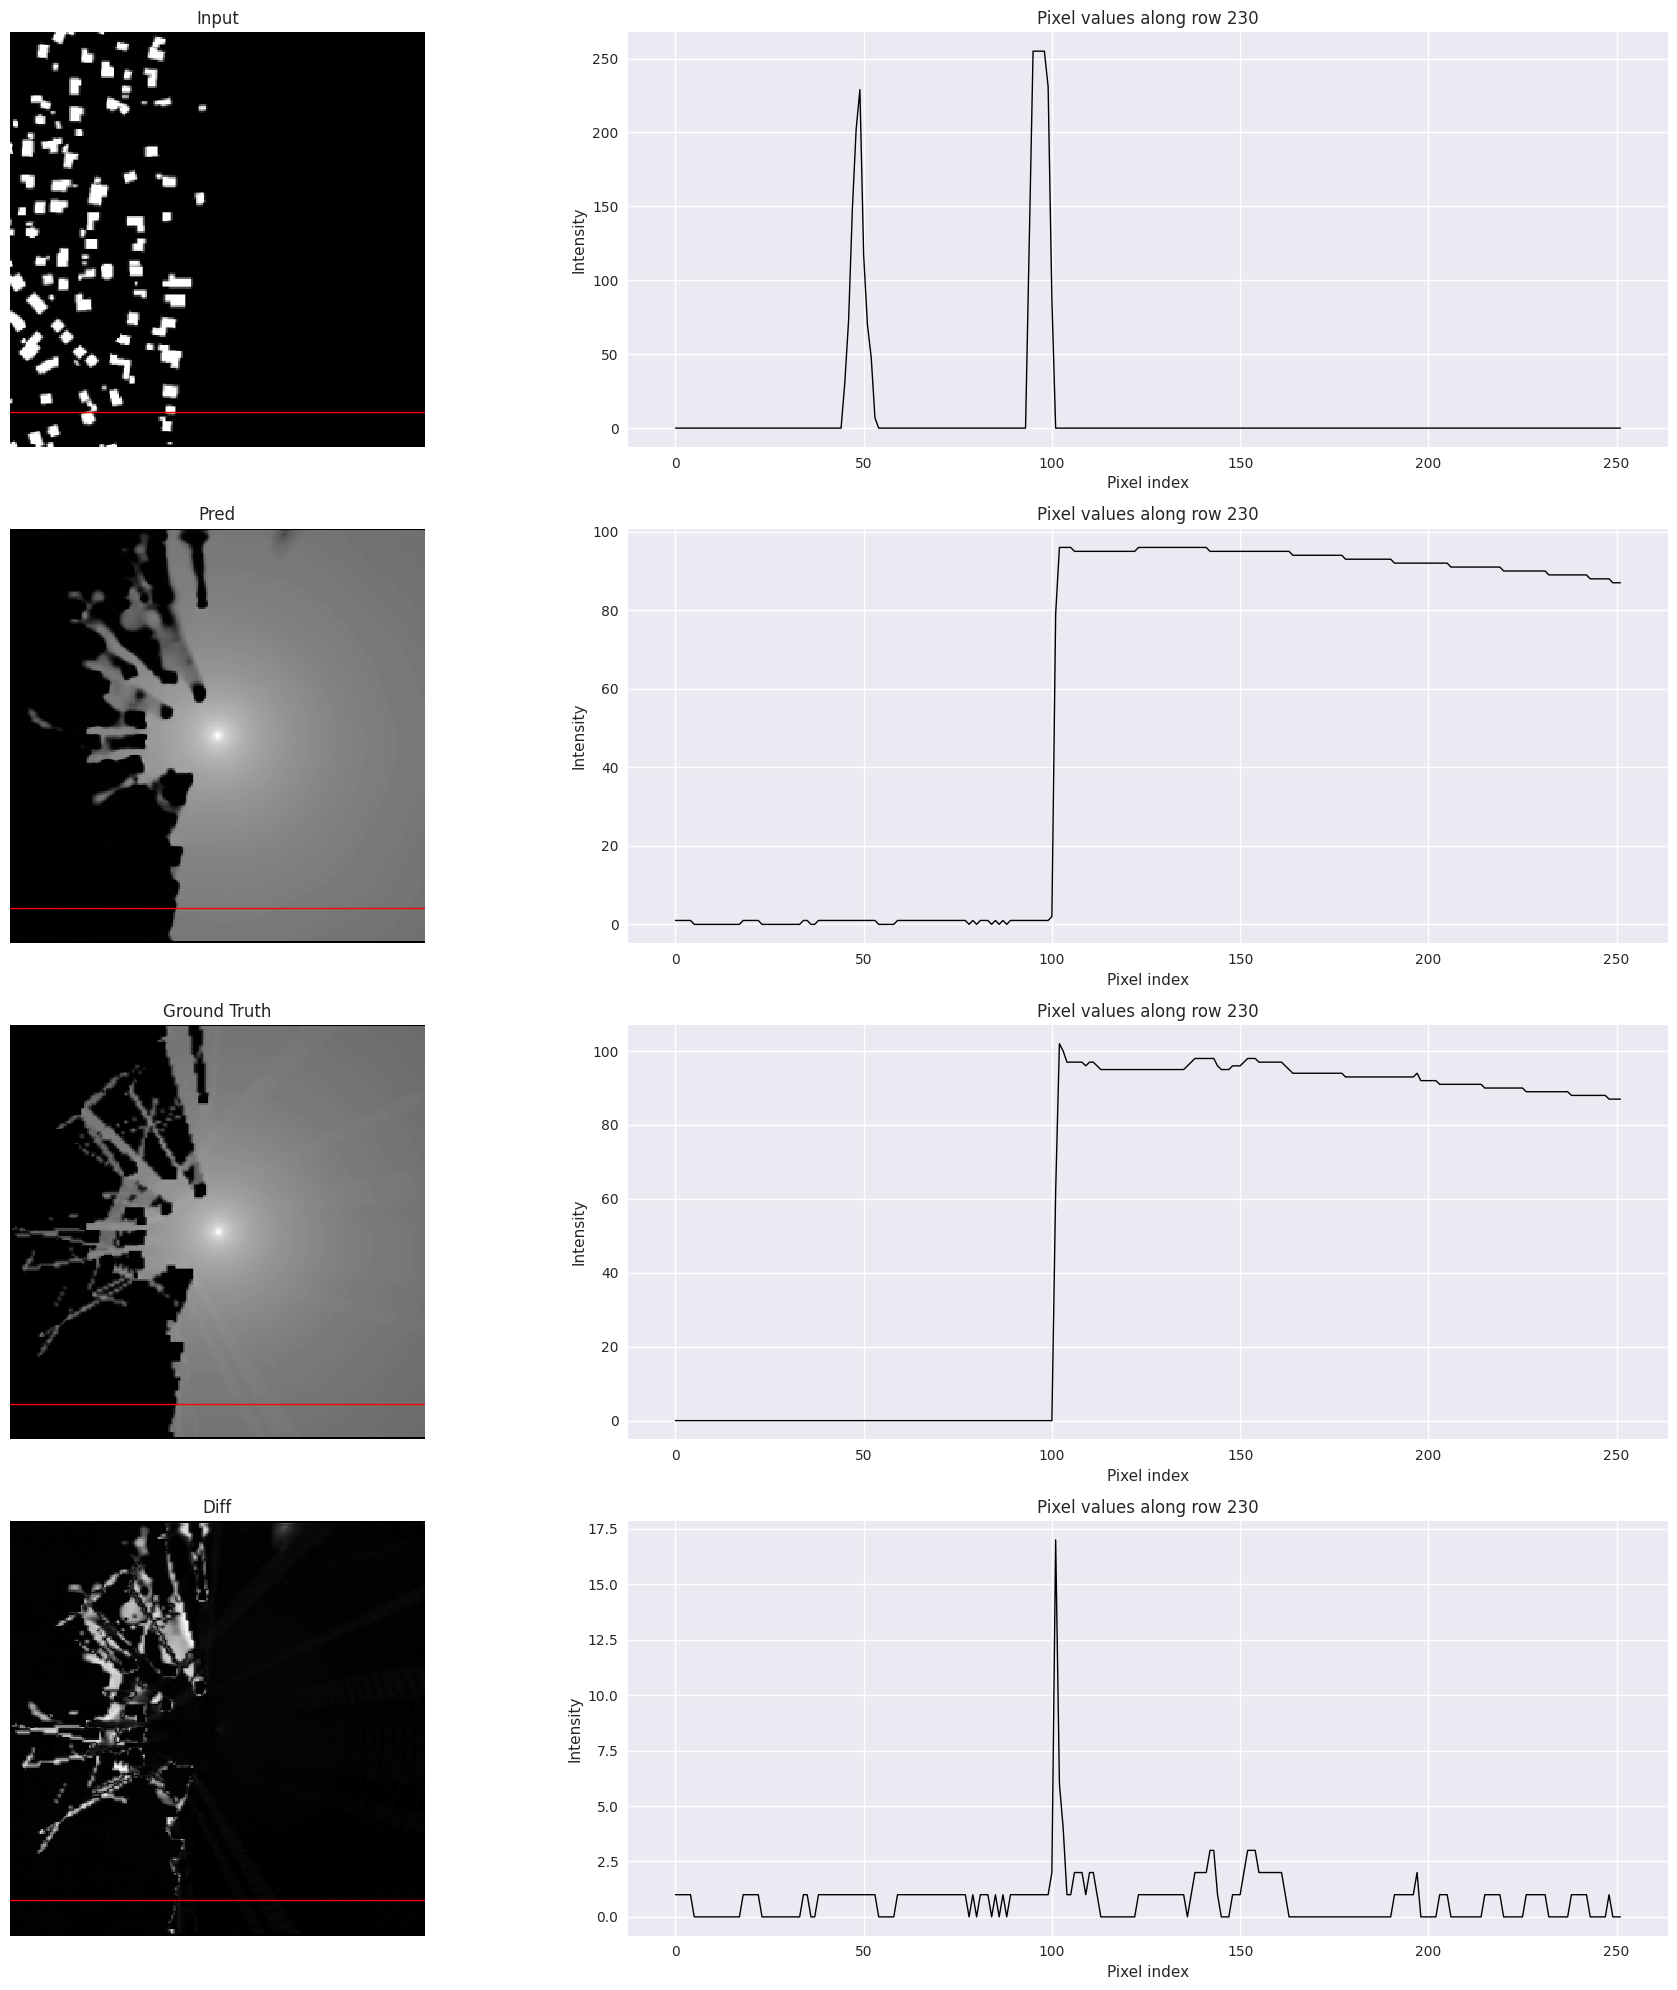

In [155]:
def show_image_with_line_and_profile(imgs, axis='row', index=None):
    """
    Show a grayscale image with a selected row or column highlighted,
    and plot its pixel values in a second subplot.

    Parameters:
    - img: 2D NumPy array (grayscale)
    - axis: 'row' or 'column'
    - index: index of the row or column to highlight (default = center)
    """
    assert axis in ['row', 'column'], "axis must be 'row' or 'column'"
    h, w = imgs[0].shape

    if index is None:
        index = h // 2 if axis == 'row' else w // 2

    # Create subplots
    fig, ax = plt.subplots(4, 2, figsize=(20, 10*2))

    for cur_img, cur_ax, cur_name in zip(imgs, ax, ["Input", "Pred", "Ground Truth", "Diff"]):
        cur_ax_1 = cur_ax[0]
        cur_ax_1.imshow(cur_img, cmap='gray', interpolation='nearest')
        if axis == 'row':
            cur_ax_1.axhline(index, color='red', linewidth=1)
        else:
            cur_ax_1.axvline(index, color='red', linewidth=1)
        cur_ax_1.set_title(cur_name)
        cur_ax_1.set_xticks([])
        cur_ax_1.set_yticks([])

        # Extract line
        values = cur_img[index, :] if axis == 'row' else cur_img[:, index]
        x = np.arange(len(values))

        cur_ax[1].plot(x, values, color='black', linewidth=1)
        cur_ax[1].set_title(f'Pixel values along {axis} {index}')
        cur_ax[1].set_xlabel('Pixel index')
        cur_ax[1].set_ylabel('Intensity')
        cur_ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    return values


show_image_with_line_and_profile(imgs=[img_1, img_2, img_3, img_4], axis=axis, index=index);

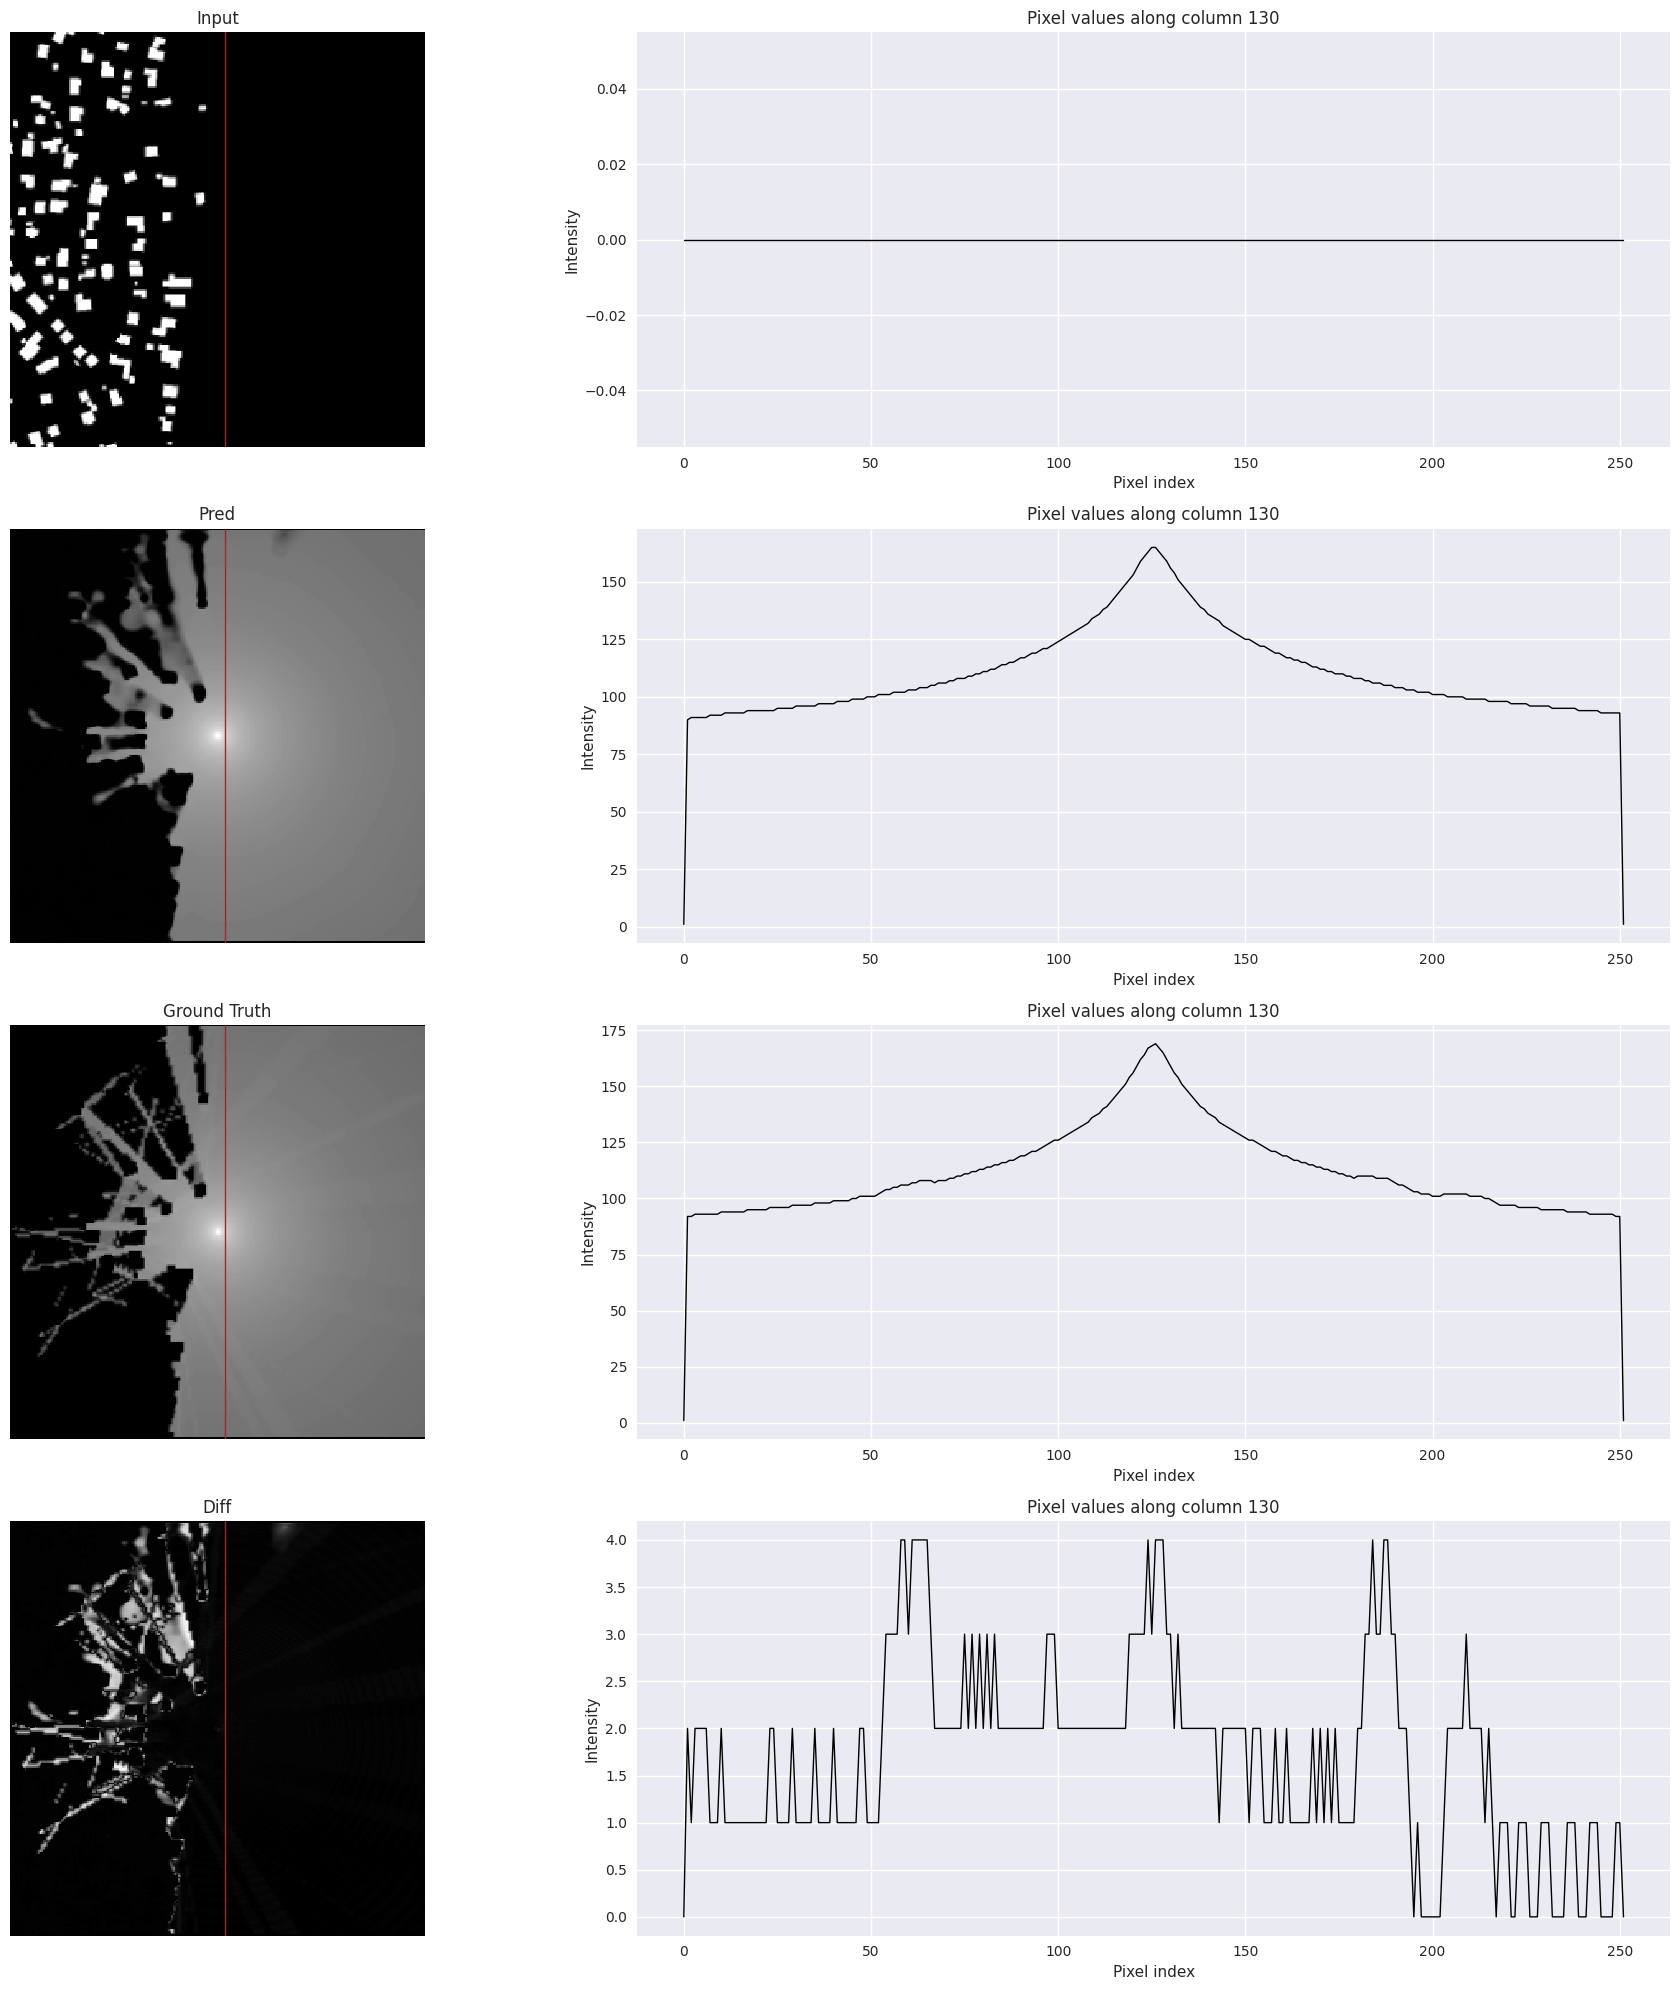

In [156]:
show_image_with_line_and_profile(imgs=[img_1, img_2, img_3, img_4], axis="column", index=130);